In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp
import glob
import time
from tqdm import tqdm
import os
import sys
import pandas as pd
from skmap.catalog import s3_setup, DataCatalog
from skmap.loader import TiledDataLoader
from skmap.misc import find_files, GoogleSheet, ttprint
import geopandas as gpd
from minio import Minio
import rasterio
import pyproj
from shapely.geometry import Point
import requests
import warnings
# from skgstat import Variogram
from shapely.geometry import Point
from eumap.mapper import SpaceOverlay
from rasterstats import zonal_stats

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

years = [2000,2004,2008,2012,2016,2020,2022]
positions = ['m','p025','p975']

# select representative nuts region

In [2]:
# nuts = gpd.read_file('/home/xuemeng/work_xuemeng/soc/data/NUTS_RG_20M_2021_3035.shp')
# nuts = nuts.loc[nuts['CNTR_CODE']=='DE']
# nuts = nuts.loc[nuts['LEVL_CODE']==3]

In [3]:
# results = {}

# for po in positions:
#     for iy in range(1,len(years)):
        
#         year = years[iy-1]
#         year_next = years[iy]
#         ttprint(f'----------------{po}, {year}--------------------')
        
#         raster_file = f'http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_{po}_30m_b0cm..20cm_{year}0101_{year_next}1231_eu_epsg.3035_v20240804.tif'

#         stats = zonal_stats(nuts, raster_file, stats="mean", geojson_out=True)
        
#         raster_name = f'ocd_{po}_{year}.{year_next}'
#         results[raster_name] = [feature['properties']['mean'] for feature in stats]


# # Add results back to the GeoDataFrame
# for raster_name, means in results.items():
#     nuts[raster_name + '_mean'] = means
    
# nuts.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts3_de_mean.csv',index=False)

In [4]:
# import pandas as pd
# from scipy.stats import theilslopes

# time = [2002, 2006, 2010, 2014, 2018, 2021]
# ml = ['ocd_m_2000.2004_mean',
#  'ocd_m_2004.2008_mean',
#  'ocd_m_2008.2012_mean',
#  'ocd_m_2012.2016_mean',
#  'ocd_m_2016.2020_mean',
#  'ocd_m_2020.2022_mean']

# def calculate_theilsen(row):
#     y = row[ml].values  # Extract values of the specified columns
#     slope, intercept, _, _ = theilslopes(y, time)  # Calculate Theil-Sen slope
#     return slope

# nuts['ocd_mean_theilsen_slope'] = nuts.apply(calculate_theilsen, axis=1)


In [5]:
# nuts['ocd_mean_theilsen_slope'].hist(bins=40)

In [6]:
# nuts_slope = nuts.loc[nuts['ocd_mean_theilsen_slope'].abs()>0.5]
# nuts_slope = nuts_slope.drop(columns = ['FID'])
# nuts_slope.to_file('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts3.de_mean_slope.gpkg',driver='GPKG')


# nuts_example = nuts.loc[nuts['NUTS_NAME'].isin(['Unterallgäu','Memmingen, Kreisfreie Stadt'])]
# nuts_example = nuts_example.drop(columns = ['FID'])
# merged_nuts = gpd.GeoSeries([nuts_example.iloc[0].geometry, nuts_example.iloc[1].geometry]).unary_union
# # merged_nuts.to_file('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts3_example_slope.gpkg',driver='GPKG')
# merged_nuts_gdf = gpd.GeoDataFrame(geometry=[merged_nuts])
# merged_nuts_gdf.crs = 'EPSG:3035'
# merged_nuts_gdf.to_file('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts3_example_slope.gpkg', driver='GPKG')


# Get the map values for subsamples in AOA

In [7]:
# # sub-sample the points
# years = [2000,2004,2008,2012,2016,2020,2022]

# fn = []
# for iy in range(1,len(years)):
#     start = years[iy-1]
#     end = years[iy]
#     fne = [f'http://192.168.1.30:8333/tmp-eumap-ai4sh/v8/oc_iso.10694.1995.kg.m3_m_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20241216.tif',
#           f'http://192.168.1.30:8333/tmp-eumap-ai4sh/v8/oc_iso.10694.1995.kg.m3_p025_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20241216.tif',
#           f'http://192.168.1.30:8333/tmp-eumap-ai4sh/v8/oc_iso.10694.1995.kg.m3_p975_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20241216.tif']
#     fn.extend(fne)
    
# fn = [Path(ii) for ii in fn]
# sub = gpd.read_file(f'/home/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts.eg_random.points.gpkg')
# temp = SpaceOverlay(
#         points=sub, 
#         fn_layers=fn, verbose=True
# ).run()

# fn = [str(a) for a in fn]
# fname = ['ocd_' + a.split('_')[2] + '_' + a.split('_')[5][0:4] + '.' + a.split('_')[6][0:4] for a in fn]
# fn = [ii.split('/')[-1][0:-4] for ii in fn]
# name_map = dict(zip(fn,fname))
# temp = temp.rename(columns = name_map)

# ## get the point level std
# ll = ['ocd_m_2000.2004',
#       'ocd_m_2004.2008',
#       'ocd_m_2008.2012',
#       'ocd_m_2012.2016',
#       'ocd_m_2016.2020',
#       'ocd_m_2020.2022']

# for l in ll:
#     std = l.replace('_m_','_std_')
#     pu = l.replace('_m_','_p975_')
#     pl = l.replace('_m_','_p025_')
    
#     temp[std] = (temp[pu] - temp[pl])/4
    
# temp = temp.drop(columns=['overlay_id'])
# temp.to_csv(f'{folder_path}/data_subsample.ocd.variogram.csv',index=False)


# Get statistics of AOA

In [8]:
merged_nuts = gpd.read_file(f'/home/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts3_example_slope.gpkg')

results = {}
for po in positions:
    for iy in range(1,len(years)):
        
        year = years[iy-1]
        year_next = years[iy]
        ttprint(f'----------------{po}, {year}--------------------')
        
        
        raster_file = f'http://192.168.1.30:8333/tmp-eumap-ai4sh/v8/oc_iso.10694.1995.kg.m3_{po}_30m_b0cm..20cm_{year}0101_{year_next}1231_eu_epsg.3035_v20241216.tif'
        stats = zonal_stats(merged_nuts, raster_file, stats="mean", geojson_out=True)
        raster_name = f'ocd_{po}_{year}.{year_next}'
        results[raster_name] = [feature['properties']['mean'] for feature in stats]
        
nuts_eg = pd.DataFrame(columns=['year','time','ocd_m','ocd_p025','ocd_p975'])
time = ['2000.2004','2004.2008','2008.2012','2012.2016','2016.2020','2020.2022']
year = [2002, 2006, 2010, 2014, 2018, 2021]
nuts_eg['time'] = time
nuts_eg['year'] = year


for keys in results:
    if keys.split('_')[1] == 'm':
        nuts_eg.loc[nuts_eg['time'] == keys.split('_')[2], 'ocd_m'] = results[keys][0]
    elif keys.split('_')[1] == 'p025':
        nuts_eg.loc[nuts_eg['time'] == keys.split('_')[2], 'ocd_p025'] = results[keys][0]
    elif keys.split('_')[1] == 'p975':
        nuts_eg.loc[nuts_eg['time'] == keys.split('_')[2], 'ocd_p975'] = results[keys][0]
        
nuts_eg.to_csv('/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/data/nuts3_example_slope.csv',index=False)


In [3]:
nuts_eg

,year,time,ocd_m,ocd_p025,ocd_p975
0,2002,2000.2004,282.422761,153.516304,512.095189
1,2006,2004.2008,274.511824,140.769196,520.352841
2,2010,2008.2012,268.373626,123.038139,528.415246
3,2014,2012.2016,274.950669,130.201195,520.514585
4,2018,2016.2020,280.653145,152.049172,512.942785
5,2021,2020.2022,278.731927,142.912881,546.94501


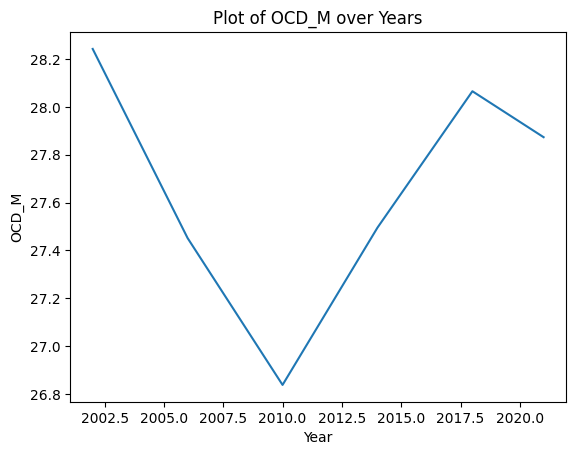

In [4]:
import matplotlib.pyplot as plt

# Now you can use plt to plot your data
plt.plot(nuts_eg['year'], nuts_eg['ocd_m']/10)
plt.xlabel('Year')
plt.ylabel('OCD_M')
plt.title('Plot of OCD_M over Years')
plt.show()

# Calculate the variance of a region 
- select 'Unterallgäu' and 'Memmingen, Kreisfreie Stadt' due to data availbility and district size
- sub-sample (if necessary)

In [9]:
# subsample of map values
from shapely import wkt
temp = pd.read_csv(f'/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/data/data_subsample.ocd.variogram.csv',low_memory=False)
temp['geometry'] = temp['geometry'].apply(wkt.loads)

factor = np.sqrt(1.3745963625991293)

# scale values
for col in temp.columns:
    if col not in ['id', 'geometry']:
        temp[col] = temp[col]/10
        if '_std_' in col:
            temp[col] = temp[col]/factor
        
gdf = gpd.GeoDataFrame(temp, geometry=temp['geometry'], crs="EPSG:3035")
gdft = gdf  # .iloc[0:500]
gdf_utm32n = gdft.to_crs(epsg=32632) # Reproject to UTM zone 32N
gdf_utm32n = gdf_utm32n.reset_index(drop=True)

# Map values
nuts_eg = pd.read_csv('/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/data/nuts3_example_slope.csv',low_memory=False)

for col in ['ocd_m','ocd_p025','ocd_p975']:
    nuts_eg[col] = nuts_eg[col]/10

In [10]:
def exponential_model(h, nugget, sill, range_):
    return nugget + (sill - nugget) * (1 - np.exp(-h / range_))

def correlation_function(h, nugget, sill, range_):
    # Calculate the variogram value at distance h
    gamma_h = exponential_model(h, nugget, sill, range_)
    # Calculate and return the correlation function value
    return (sill - gamma_h) / sill

params_exponential = np.array([ 0.78881424,  1.        , 30.99414487])

In [11]:
### organize data pairs
agg_var = []
agg_var2 = []
for ty in ['2000.2004', '2004.2008', '2008.2012', '2012.2016', '2016.2020', '2020.2022']:
    ttprint(ty)
    all_dists = []
    ms = []
    pnt1 = []
    pnt2 = []
    std1 = []
    std2 = []
    rho = []

    for index, row in gdf_utm32n.iterrows():
        iii = index + 1
        reference_point = gdf_utm32n.iloc[index].geometry
        dists = gdf_utm32n.iloc[iii:].geometry.distance(reference_point).values / 1000

        pnt1.extend([gdf_utm32n.iloc[index]['id']] * len(dists))
        pnt2.extend(gdf_utm32n.iloc[iii:]['id'].values.tolist())

        std1.extend([gdf_utm32n.iloc[index][f'ocd_std_{ty}']] * len(dists))
        std2.extend(gdf_utm32n.iloc[iii:][f'ocd_std_{ty}'].values.tolist())

        rho.extend(correlation_function(dists, *params_exponential))

        ms.append(len(dists))  # Corrected to use dists instead of diffs
        all_dists.extend(dists)
        
    print(len(rho))
    rho = rho*2
    std1 = std1*2
    std2 = std2*2
    
    print(len(rho))
    rho.extend([1]*len(gdf_utm32n))
    std1.extend(gdf_utm32n[f'ocd_std_{ty}'].values.tolist())
    std2.extend(gdf_utm32n[f'ocd_std_{ty}'].values.tolist())
    
    print(len(rho))
    rho_array = np.array(rho)
    std1_array = np.array(std1)
    std2_array = np.array(std2)

    agg_var.append(np.nansum(rho_array * std1_array  * std2_array)/len(temp)**2) # grid size square, * factor
    agg_var2.append(np.nansum(rho_array * std1_array * std2_array)/len(rho_array)) # add up


[10:22:44] 2000.2004
15398475
30796950
30802500
[10:23:25] 2004.2008
15398475
30796950
30802500
[10:24:07] 2008.2012
15398475
30796950
30802500
[10:24:49] 2012.2016
15398475
30796950
30802500
[10:25:30] 2016.2020
15398475
30796950
30802500
[10:26:11] 2020.2022
15398475
30796950
30802500


In [12]:
nuts_eg['agg_var'] = agg_var2
nuts_eg['agg_std'] = np.sqrt(nuts_eg['agg_var'])
# nuts_eg['mean_std'] = (nuts_eg['ocd_p975'] - nuts_eg['ocd_p025'])*factor/4
nuts_eg

,year,time,ocd_m,ocd_p025,ocd_p975,agg_var,agg_std
0,2002,2000.2004,28.242276,15.351630,51.209519,6.314176,2.512802
1,2006,2004.2008,27.451182,14.076920,52.035284,7.123622,2.669011
2,2010,2008.2012,26.837363,12.303814,52.841525,8.133686,2.851962
3,2014,2012.2016,27.495067,13.020119,52.051458,7.532263,2.744497
4,2018,2016.2020,28.065314,15.204917,51.294278,6.444797,2.538660
5,2021,2020.2022,27.873193,14.291288,54.694501,8.042003,2.835842


In [13]:
nuts_eg.to_csv('/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/data/nuts3_example.aggregated_slope.csv',index=False)

# Design-based variance

In [16]:
df = pd.read_csv(f'/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/data/data_de.depth.organized.csv', low_memory=False)
de = df.loc[df['depth'] != 'upper 20']

geometry = [Point(xy) for xy in zip(de['lon'], de['lat'])]
de = gpd.GeoDataFrame(de, geometry=geometry, crs="EPSG:4326")
de = de.to_crs("EPSG:3035")

rg = gpd.read_file(f'/home/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts3_example_slope.gpkg')

nuts3 = gpd.sjoin(de, rg, predicate='within')
nuts3 = nuts3.drop(columns=['index_right'])
nut3 = nuts3[['time', 'lat', 'lon', 'hzn_dep', 'id', 'ref', 'nuts0', 'lc_survey','ocd','tile_id', 'depth', 
              'ocd_p025', 'ocd_map', 'ocd_p975', 'std','residual', 'std_rsd', 'geometry']]

nuts3.to_csv(f'/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/data/nuts3_aggregation_samples.csv',index=False)

In [26]:
ll = len(nuts3)
mmean = nuts3['ocd'].mean()
vvar = np.sum((nuts3['ocd']-mmean)**2)/ll/(ll-1)
# vvar = nuts3['ocd'].var()/ll
# sstd = nuts3['ocd'].std()

nuts_eg['sample_mean'] = [np.nan,np.nan,np.nan,mmean,np.nan,np.nan]
nuts_eg['sample_var'] = [np.nan,np.nan,np.nan,vvar,np.nan,np.nan]
nuts_eg['sample_size'] = [0,0,0,ll,0,0]
nuts_eg['sample_std'] = np.sqrt(nuts_eg['sample_var'])
nuts_eg

,year,time,ocd_m,ocd_p025,ocd_p975,agg_var,agg_std,sample_mean,sample_var,sample_size,sample_std,ocd_map_std
0,2002,2000.2004,28.242276,15.351630,51.209519,6.314176,2.512802,NaN,NaN,0,NaN,7.646050
1,2006,2004.2008,27.451182,14.076920,52.035284,7.123622,2.669011,NaN,NaN,0,NaN,8.093939
2,2010,2008.2012,26.837363,12.303814,52.841525,8.133686,2.851962,NaN,NaN,0,NaN,8.643938
3,2014,2012.2016,27.495067,13.020119,52.051458,7.532263,2.744497,27.875253,3.482578,16,1.866167,8.322731
4,2018,2016.2020,28.065314,15.204917,51.294278,6.444797,2.538660,NaN,NaN,0,NaN,7.695407
5,2021,2020.2022,27.873193,14.291288,54.694501,8.042003,2.835842,NaN,NaN,0,NaN,8.615259


In [18]:
nuts_eg.to_csv('/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/data/nuts3_example.aggregated_slope.csv',index=False)

In [19]:
(52.051458-15.204917)/4/factor

7.856862229598212

<Axes: >

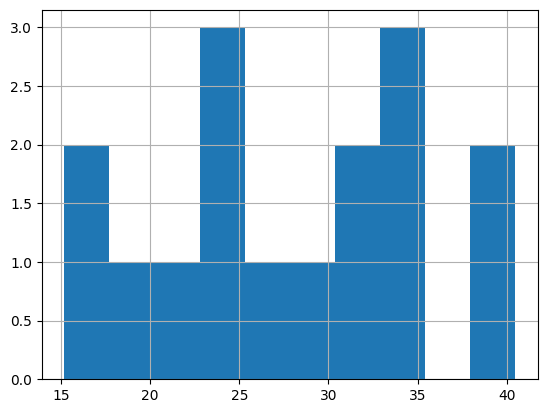

In [23]:
nuts3['ocd'].hist()

# Plot

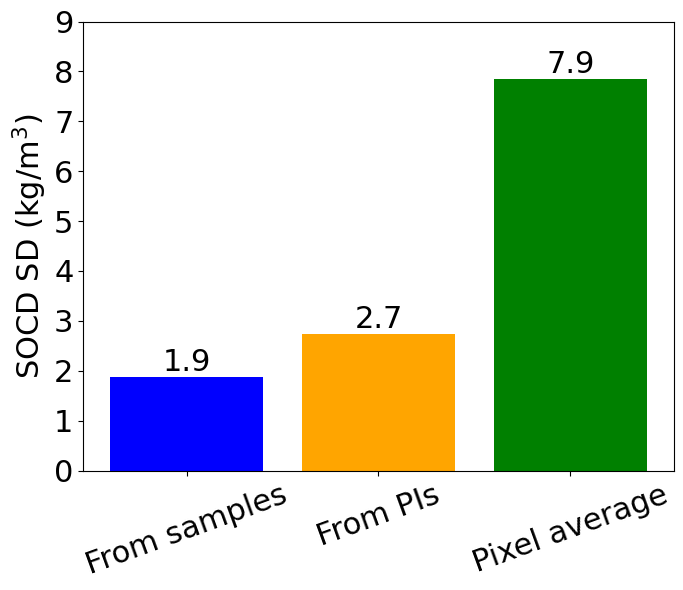

In [29]:
values = [1.866167, 2.744497, 7.856862229598212]
methods = ['From samples','From PIs','Pixel average']

plt.figure(figsize=(7, 6))
bars = plt.bar(methods, values, color=['blue', 'orange', 'green'])

# Add y-axis label
plt.ylabel('SOCD SD (kg/m$^3$)', fontsize=22)
# plt.title('SD comparison', fontsize=24)

# Place the value at the top of each bar, rounded to 1 decimal
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.1f}', 
             ha='center', va='bottom', fontsize=22, color='black')

# Customize tick labels and adjust their font size
plt.xticks(fontsize=22, rotation=20, ha='center')#,
plt.yticks(fontsize=22)
plt.ylim([0,9])
plt.tight_layout()
plt.savefig("/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/figure/plot_aggregation.uncertainty_compare.svg", format='svg')

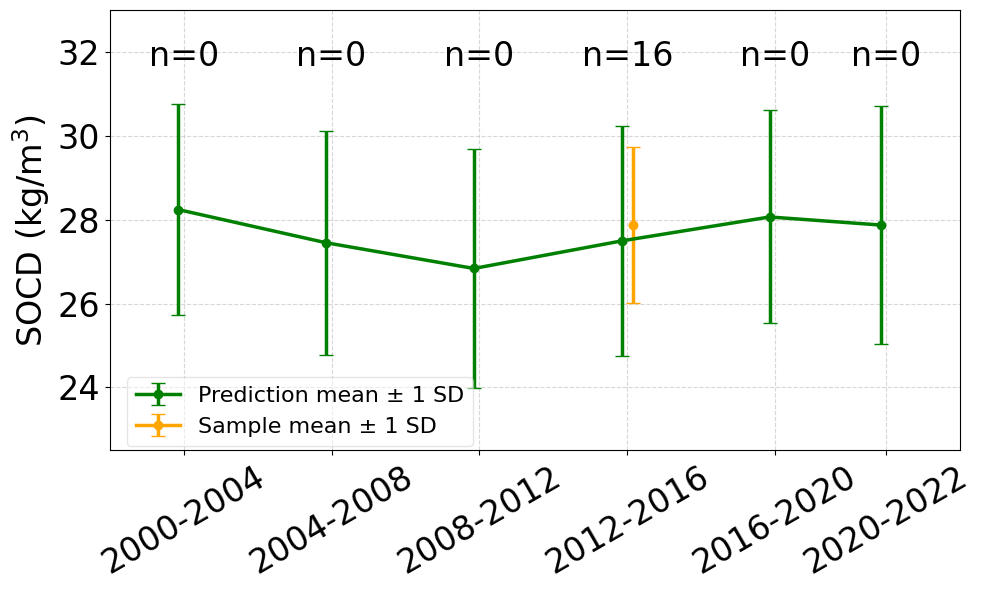

In [31]:
nuts_eg['ocd_map_std'] = (nuts_eg['ocd_p975'] - nuts_eg['ocd_p025'])/factor/4
time = ['2000-2004','2004-2008','2008-2012','2012-2016','2016-2020','2020-2022']

plt.figure(figsize=(10, 6))

# Define offsets for the x positions to separate the two time series
x_offset = 0.15

# Plotting OCD_M with agg_std on the left side of each year
plt.errorbar(nuts_eg['year'] - x_offset, nuts_eg['ocd_m'], yerr=nuts_eg['agg_std'], fmt='-o', label='Prediction mean ± 1 SD', capsize=5, color='green',linewidth=2.5)
# # Plotting model-based 
# plt.errorbar(nuts_eg['year'] - x_offset, nuts_eg['ocd_m'], yerr=nuts_eg['ocd_map_std'], fmt='-o', label='Model-based', capsize=5, color='blue',linewidth=2.5)
# Plotting Sample Mean with sample_std on the right side of each year
plt.errorbar(nuts_eg['year'] + x_offset, nuts_eg['sample_mean'], yerr=nuts_eg['sample_std'], fmt='-o', label='Sample mean ± 1 SD', capsize=5, color='orange',linewidth=2.5)

# Adding sample size text for each year in the middle
for i, row in nuts_eg.iterrows():
    plt.text(row['year'], 31.5, f"n={row['sample_size']:.0f}", ha='center', va='bottom', fontsize=24)

# Setting the x-ticks with time labels
plt.xticks(nuts_eg['year'], time, fontsize=24, rotation=30)
plt.yticks(fontsize=24)

# Labels, title, and legend
# plt.xlabel('Time period', fontsize=24)
plt.ylabel('SOCD (kg/m$^3$)', fontsize=24)
# plt.title('Regional SOCD mean ± 1 SD', fontsize=24)
plt.legend(fontsize=16,loc=(0.02, 0.01), framealpha=0.5)
plt.ylim([22.5, 33])
plt.xlim([2000,2023])
# Adding a grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/figure/plot_time.series.uncertainty.svg", format='svg')
plt.show()

# Map visualization

In [35]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np

raster_files = [
    'http://192.168.1.30:8333/tmp-eumap-ai4sh/v8/oc_iso.10694.1995.kg.m3_p025_30m_b0cm..20cm_20120101_20161231_eu_epsg.3035_v20241216.tif',
    'http://192.168.1.30:8333/tmp-eumap-ai4sh/v8/oc_iso.10694.1995.kg.m3_p975_30m_b0cm..20cm_20120101_20161231_eu_epsg.3035_v20241216.tif'
]

# Clip the first raster (p025)
with rasterio.open(raster_files[0]) as src:
    clipped_p025, clipped_transform = mask(src, rg.geometry, crop=True)

# Clip the second raster (p975)
with rasterio.open(raster_files[1]) as src:
    clipped_p975, _ = mask(src, rg.geometry, crop=True)

# Calculate the clipped image using the difference and factor
clipped_image = (clipped_p975 - clipped_p025) / factor / 40

# Update metadata with the correct data type and NoData value
clipped_meta = src.meta.copy()
clipped_meta.update({
    'driver': 'GTiff',
    'height': clipped_image.shape[1],
    'width': clipped_image.shape[2],
    'transform': clipped_transform,
    'dtype': 'float32',
    'nodata': 0.0
})

# Save the resulting clipped raster
output_clipped = '/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/figure/nuts3.eg_map_std.tif'
with rasterio.open(output_clipped, 'w', **clipped_meta) as dest:
    dest.write(clipped_image.astype('float32'))
print(f"Saved clipped raster: {output_clipped}")

Saved clipped raster: /home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/figure/nuts3.eg_map_std.tif


In [ ]:
# # Save the aggregated std raster as float
# agg_std = nuts_eg.loc[nuts_eg['year'] == 2014, 'agg_std'].values[0]
# new_raster_data = np.ones_like(clipped_image, dtype='float32') * agg_std
# new_raster_data_agg = np.where(clipped_image[0] == 0, 0, new_raster_data) 
# output_new_raster = output_clipped.replace('_map_', '_agg_')
# with rasterio.open(output_new_raster, 'w', **clipped_meta) as dest:
#     dest.write(new_raster_data_agg)
# print(f"Saved aggregated std raster as float: {output_new_raster}")

# # Save the sample std raster as float
# sample_std = nuts_eg.loc[nuts_eg['year'] == 2014, 'sample_std'].values[0]
# new_raster_data = np.ones_like(clipped_image, dtype='float32') * sample_std
# new_raster_data_sample = np.where(clipped_image[0] == 0, 0, new_raster_data) 
# output_new_raster = output_clipped.replace('_map_', '_sample_')
# with rasterio.open(output_new_raster, 'w', **clipped_meta) as dest:
#     dest.write(new_raster_data_sample)
# print(f"Saved sample std raster as float: {output_new_raster}")